Created on 12:39:58 2021

@author: BESP

# ACROSS SITES INTERACTIONS: SUPERFICIAL ANALISYS



In [46]:
# LIBRARIES
import networkx as nx
import pandas as pd
import os
import numpy as np
import collections
import random
import matplotlib.pyplot as plt
from upsetplot import from_contents
from heapq import merge
from upsetplot import plot

In [4]:
# INPUTS
#DIRwork1 = "C:/Users/BESP/Documents/LCG/SXTO/REDES/BARS/DATA"
DATAfile1 = "../data/jarr_MATRIX_RED.csv"   # Adjacency matrix of the complete network in bassilus antagonism interactions
METADATA1 = "../data/jarr_groups.csv"   # To every strains it is specified the origin site

## ABOUT THE DATA...
The data is about Bacillus strains sampled in five sites of Cuatro Cienegas.

The data describes the presence/absence of antagonism interactions.

In [5]:
# LOCALIZE
#os.chdir(DIRwork1)
print ("You are located at", os.getcwd())

# DEFINE DOCUMENTS, NETWORKS, ETC
MATRIX1 = pd.read_csv(DATAfile1, index_col = 0)
GROUPS1 = pd.read_csv(METADATA1, index_col = 0)

You are located at C:\Users\BESP\Documents\LCG\SXTO\REDES\BARS\DATA\CODE


## SOME FUNCTIONS

**Transforms our input matrix data into an edge list**

EDGE LIST:
- OutputID(Who is atagonizing)   InputID (Who is being antagonized)   Value (1:Exists antagonism; 0:Does not exists antagonism)

In [6]:
# MATRIX TO EDGELIST
## Input: Matrix; Output: Edgelist; It is necessary that the 0 in the matrix does not mean anything 
def matrixToEdge(MATRIX):   
    INTERnum = MATRIX.sum().sum()   # To coroborate that the number of interactions is the same as the number of rows in edgelist 
    
    MATRIX = MATRIX.replace(0, np.nan)   # If we use 0 instead of NAN, the stack includes the non interactions in the edgelist variable
    EDGElist = MATRIX.stack().reset_index()   # Transforms Matrix to Edgelist
    EDGElist.columns = ["OutputID", "InputID", "Value"]
    
    ROWSnum = len(EDGElist.index)
    
    print("Number of interactions in MATRIX: ", INTERnum, "\tNumber of interactions in edgelist: ", ROWSnum)
    
    return(EDGElist)




**Asigns site of interactions (or other metadata) to an edge list:**

EDGE LIST:
- OutputID   InputID   Value   InSITE (Origin site of the InputID)   OutSITE (Origin site of the OuputID)

In [7]:
# APPEND GROUPS TO EDGELIST
### Input: EdgeList, Metadata; Output: Edgelist with new colums of metadata; ******It uses only group metadata******, Makes differences between input and output metadata
def assignMetadata(EL, GROUPS):
    INsite = []
    OUTsite = []

    for i in EL.index:
        OUTvalue = GROUPS.loc[EL["OutputID"][i]]["group"]   # Locate the group of the Output strain
        OUTsite.append(OUTvalue)

        INvalue = GROUPS.loc[EL["InputID"][i]]["group"]   # Locate the group of the Input strain
        INsite.append(INvalue)

    EL["InSITE"] = OUTsite
    EL["OutSITE"] = INsite

    return(EL)
    

**Selecting only the across sites interactions. (Removing antagonism interactions of cells with the same origin site)**

In [8]:
# REDEFINING THE NET, ONLY ACROSS INTERACTIONS
### Input: EdgeList; Output: EdgeList with only across interactions
def totalToAcross(EL):
    for i in EL.index:   # Remove the intra site interactions
        if EL["OutSITE"][i] == EL["InSITE"][i]:
            EL = EL.drop([i])
    return(EL)




**Obtaining the degrees and compiling information in a matrix.**

For each node the degree is calculated

There are two types of degree computed. Given a node N:
- Outdegree: ¿How many strains antagonize N?
- Indegree: ¿How many strains are antagonizing N?

Matrix
- Node identity (In/Out)Degree

In [9]:
# OBTAIN THE DEGGRES OF EACH NODE IN A PHENOMENOM OF INTEREST
### Input: Network of interest, METADATA as a source of all the nodes included in the phenomenom; Output: Data frame of nodes with degrees
def degreesOpe(NETWORK, METADATA):
    NODES = []
    INDEGREES = []
    OUTDEGREES = []
        
    for i in nx.nodes(NETWORK):   # Collect nodes and degrees
        NODES.append(i)
        OUTDEGREES.append(NETWORK.out_degree(i))
        INDEGREES.append(NETWORK.in_degree(i))
        
    DEGREES = pd.DataFrame({"OutDegree": OUTDEGREES, "InDegree": INDEGREES}, index = NODES)   # Join information about nodes and degrees
    
    # To see wich nodes are not included in edgelist (that have not interactions)
    SETtotal = set(list(METADATA.index))
    SETParcial = set(list(DEGREES.index))
    UNINCLUDED = list(SETtotal - SETParcial)
    
    ZEROS = list(np.zeros(len(UNINCLUDED)))
    
    DF = pd.DataFrame({"OutDegree": ZEROS, "InDegree": ZEROS}, index = UNINCLUDED)   # Nodes that are not included in edgelist because the have not interactions
   
    DEGREES = DEGREES.append(DF)   # New complete set of degrees
    
    
    DEGREESgroups = pd.merge(DEGREES, METADATA, left_index=True, right_index=True) # The DEGREES and GROUPS data frame must have certain format (The output of the function processing)
    
    
    return(DEGREESgroups)


    
    

**Classifying each node**

There are two characteristics, a node can be:
- Sensitive / Resistant
- Antagonist / Not antagonist

Matrix
- Node identity   (In/Out)Degree  Class

In [10]:
# DETERMINE IF A NODE IS X OR Y BASED ON THE DEGREE
### Input: Data frame of degrees of each node, Treshold to classify; Output: Data frame of the degree and class of each node
def classify(DEGREE, TRESHOLD=0):
    CLASSensitive = []
    CLASSantagonist = []
    for i in DEGREE.index:
        if DEGREE["InDegree"][i] <= TRESHOLD:
            CLASSensitive.append("Resistant")
        else:
            CLASSensitive.append("Sensitive")
            
        if DEGREE["OutDegree"][i] <= TRESHOLD:
            CLASSantagonist.append("No Antagonist")
        else:
            CLASSantagonist.append("Antagonist")
        
    DEGREE["ClassANA"] = CLASSantagonist
    DEGREE["ClassSR"] = CLASSensitive
    
    return(DEGREE)
    

**Compilation of the functions necesary to stimate the degree and classification of the interactions in a across network**

In [11]:
# COMPILE ALL THE PROCESS NEEDED TO DETERMINE THE ACROSS DEGREES OF A METWORK
### Input: Global Adjacency Matrix, METADATA (In this case group of each node); Output: Data frame of degrees and class of each node
def processing(MATRIX, METADATA):
    print("Transforming matrix to edgelist....")
    EDGElist = matrixToEdge(MATRIX)  
    print("Assigning Groups....")
    assignMetadata(EDGElist, METADATA)
    print("Removing intersites interactions....")
    EDGEacross = totalToAcross(EDGElist)
    
    print("Obtaining degrees....")
    NET = nx.from_pandas_edgelist(EDGEacross, source="OutputID", target="InputID", create_using=nx.DiGraph())
    DEGREES = degreesOpe(NET, METADATA)
    
    print("Classifying...")
    classify(DEGREES)
    
    print("DONE =D....")
    return(EDGEacross, NET, DEGREES)





In [12]:
def processing2(EDGE, METADATA):
    print("Obtaining degrees....")
    NET = nx.from_pandas_edgelist(EDGE, source="OutputID", target="InputID", create_using=nx.DiGraph())
    DEGREES = degreesOpe(NET, METADATA)
    
    print("Classifying...")
    classify(DEGREES)
    
    print("DONE =D....")
    return(NET, DEGREES)

**Sort the nodes by group and assign a color by group.**

The position and color are used to make a circular draw of the network

In [13]:
def CircularSortParameters(NET, GRUPS1, COLORS):
    EDGESnodes = list(nx.nodes(NET))   # All nodes
    GROUPSedgesIncluded = GROUPS1[GROUPS1.index.isin(EDGESnodes)]   # Select metadata of only the nodes present in the net interactions
    
    INDEXES = nx.circular_layout(NET)   # Obtain coordenates
    POS = {}
    for i, j in zip(GROUPSedgesIncluded.index, list(INDEXES.values())): # The index is ordered by site. Reorder the nodes position. Al the nodes of group 1 first, then the group 2....
        POS[i] = j
        
    
    COLORS = ["#FF4653", "#F4ABAA", "#CAE7DF", "#2A3166", "#DDEDF4"]   # Paleta
    
    GROUPS = list(set(GROUPSedgesIncluded.group))   # Groups of the network

    
    REPEATS = []
    for i in GROUPS:   # How many strains of group n exist in the network?
        REPEATS.append(len(GROUPSedgesIncluded[GROUPSedgesIncluded.group == i]))

    COLORepeat = list(np.repeat(COLORS, REPEATS, axis=0))   # Color vector sorted
    COLORdic = {}
    for i, j in zip(GROUPSedgesIncluded.index, COLORepeat): # Assign a color to each node by group
        COLORdic[i] = j

    COLOR = []
    for v in NET:
        COLOR.append(COLORdic[v])   # Transforming to sorted vector of colors
        
    return(POS, COLOR)



## ANALYSIS

**Of the total across interactions (78 Strains): Edgelist, Network, Degrees matrix**

In [14]:
# TREATMENT OF DATA
### Just code*

EDGE, NET, DEGREES = processing(MATRIX1, GROUPS1)

Transforming matrix to edgelist....
Number of interactions in MATRIX:  508 	Number of interactions in edgelist:  508
Assigning Groups....
Removing intersites interactions....
Obtaining degrees....
Classifying...
DONE =D....


**Final EdgeList table**

In [15]:
EDGE

,OutputID,InputID,Value,InSITE,OutSITE
0,19b,153a,1.0,1,5
1,19b,159a,1.0,1,5
3,20b,138,1.0,1,4
4,20b,153a,1.0,1,5
5,20b,159a,1.0,1,5
...,...,...,...,...,...
499,452a,158b,1.0,14,5
500,452a,161c,1.0,14,5
501,452a,162,1.0,14,5
502,452a,163b,1.0,14,5


**Final Degree-Class table**

In [16]:
DEGREES

,OutDegree,InDegree,group,ClassANA,ClassSR
19b,2.0,0.0,1,Antagonist,Resistant
153a,0.0,13.0,5,No Antagonist,Sensitive
159a,1.0,15.0,5,Antagonist,Sensitive
20b,7.0,2.0,1,Antagonist,Sensitive
138,0.0,10.0,4,No Antagonist,Sensitive
...,...,...,...,...,...
99a,0.0,0.0,3,No Antagonist,Resistant
88,0.0,0.0,3,No Antagonist,Resistant
448a,0.0,0.0,14,No Antagonist,Resistant
39,0.0,0.0,1,No Antagonist,Resistant


# Proporción por clase

In [17]:
def pltUpsetByClass(DEGREES, TITLE="Proportions by classes"):
    ANTAGONIST = list(DEGREES[DEGREES.ClassANA == "Antagonist"].index)
    NOantagonist = list(DEGREES[DEGREES.ClassANA == "No Antagonist"].index)
    RESISTANT = list(DEGREES[DEGREES.ClassSR == "Resistant"].index)
    SENSITIVE = list(DEGREES[DEGREES.ClassSR == "Sensitive"].index)

    CONTENTS = {"Antagonist": ANTAGONIST, "No antagonist": NOantagonist, "Resistant": RESISTANT, "Sensitive": SENSITIVE}
    
    CONTENTSf = from_contents(CONTENTS)
    plot(CONTENTSf, facecolor="#2A3166")
    plt.title(TITLE, fontsize = 20)
    plt.show() 

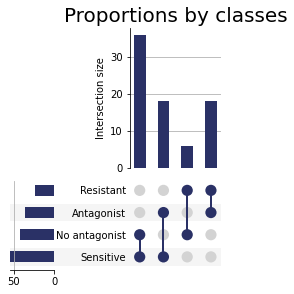

In [18]:
pltUpsetByClass(DEGREES)

# Proporción por sitios

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

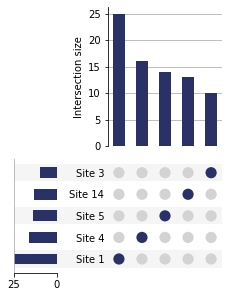

In [19]:
SITEStrains = {}
for i in set(GROUPS1.group):
    NAME = "Site " + str(i) 
    SITEStrains[NAME] = list(GROUPS1[GROUPS1.group == i].index)

    
SITEStrains
CONTENTSf = from_contents(SITEStrains)
plot(CONTENTSf, facecolor="#2A3166")

In [20]:
GROUPS = {}
for i in set(DEGREES.group):
    GROUPS[str(i)] = list(DEGREES[DEGREES.group == i].ClassANA)
    GROUPS[str(i)] = GROUPS[str(i)] + list(DEGREES[DEGREES.group == i].ClassSR)
    
from_contents(GROUPS)
#plot(CONTENTSf, facecolor="#2A3166")
    

ValueError: Got duplicate ids in a category

In [159]:
GROUPS

{'1': ['Antagonist',
  'Antagonist',
  'Antagonist',
  'Antagonist',
  'Antagonist',
  'Antagonist',
  'Antagonist',
  'Antagonist',
  'Antagonist',
  'Antagonist',
  'Antagonist',
  'No Antagonist',
  'No Antagonist',
  'No Antagonist',
  'No Antagonist',
  'No Antagonist',
  'No Antagonist',
  'No Antagonist',
  'No Antagonist',
  'No Antagonist',
  'No Antagonist',
  'No Antagonist',
  'No Antagonist',
  'No Antagonist',
  'No Antagonist',
  'Resistant',
  'Sensitive',
  'Resistant',
  'Resistant',
  'Sensitive',
  'Resistant',
  'Resistant',
  'Sensitive',
  'Resistant',
  'Sensitive',
  'Resistant',
  'Sensitive',
  'Sensitive',
  'Sensitive',
  'Sensitive',
  'Sensitive',
  'Sensitive',
  'Sensitive',
  'Sensitive',
  'Sensitive',
  'Sensitive',
  'Sensitive',
  'Sensitive',
  'Resistant',
  'Resistant'],
 '3': ['No Antagonist',
  'Antagonist',
  'No Antagonist',
  'No Antagonist',
  'No Antagonist',
  'No Antagonist',
  'Antagonist',
  'Antagonist',
  'No Antagonist',
  'No Anta

In [150]:
DEGREES


,OutDegree,InDegree,group,ClassANA,ClassSR
19b,2.0,0.0,1,Antagonist,Resistant
153a,0.0,13.0,5,No Antagonist,Sensitive
159a,1.0,15.0,5,Antagonist,Sensitive
20b,7.0,2.0,1,Antagonist,Sensitive
138,0.0,10.0,4,No Antagonist,Sensitive
...,...,...,...,...,...
112a,0.0,0.0,4,No Antagonist,Resistant
39,0.0,0.0,1,No Antagonist,Resistant
88,0.0,0.0,3,No Antagonist,Resistant
38c,0.0,0.0,1,No Antagonist,Resistant


In [21]:
def pltUpsetByClass(DEGREES, TITLE="Proportions by classes"):
    ANTAGONIST = list(DEGREES[DEGREES.ClassANA == "Antagonist"].index)
    NOantagonist = list(DEGREES[DEGREES.ClassANA == "No Antagonist"].index)
    RESISTANT = list(DEGREES[DEGREES.ClassSR == "Resistant"].index)
    SENSITIVE = list(DEGREES[DEGREES.ClassSR == "Sensitive"].index)

    CONTENTS = {"Antagonist": ANTAGONIST, "No antagonist": NOantagonist, "Resistant": RESISTANT, "Sensitive": SENSITIVE}
    
    CONTENTSf = from_contents(CONTENTS)
    plot(CONTENTSf, facecolor="#2A3166")
    plt.title(TITLE, fontsize = 20)
    plt.show() 

### The network of interactions
**Network drawing sorted by sample site**

Arrows (Gray trinagles) detone sensitivity

### PLOTING FUNCTIONS

**Network Drawing***

It recqires 3 parameters: NET (The network to draw); GROUPS (A data frame with each node and its corresponding group)
COLORS (A list of colors that represent each group).

It has other optional parameters: SAVE (Do you wanna make a file with the figure?); ATRIBUTES (Change the atributes of
the drawing); TITLE (Changes the title of the final figure).

It returns a drawing, it can also returns a file.

In [22]:
def pltNetByGroups(NET, GROUPS, COLORS, SAVE = "T", TITLEsave = 'NetworkAcross.png',ATRIBUTES = "F", TITLE="Figure 1: Antagonism Interactios Across Sites"):
    POS, COLOR = CircularSortParameters(NET, GROUPS, COLORS) # To get the layout
    
    if ATRIBUTES == "F":
        ATRIBUTES = {"font_size":15,
             "node_size":500,
             "edge_color":"silver",
             "style":"dashed",
             "arrowsize":30,
             "width":0.5,    
        }
    ATRIBUTES["pos"] = POS
    ATRIBUTES["node_color"] = COLOR
    
    plt.figure(figsize=(20,15))
    nx.draw_networkx(NET, **ATRIBUTES)
    plt.title(TITLE, fontsize=20)
    
    if SAVE == "T":
        plt.savefig("../RESULTS/FIGURES/"+TITLEsave)
    
    plt.show()
    
    

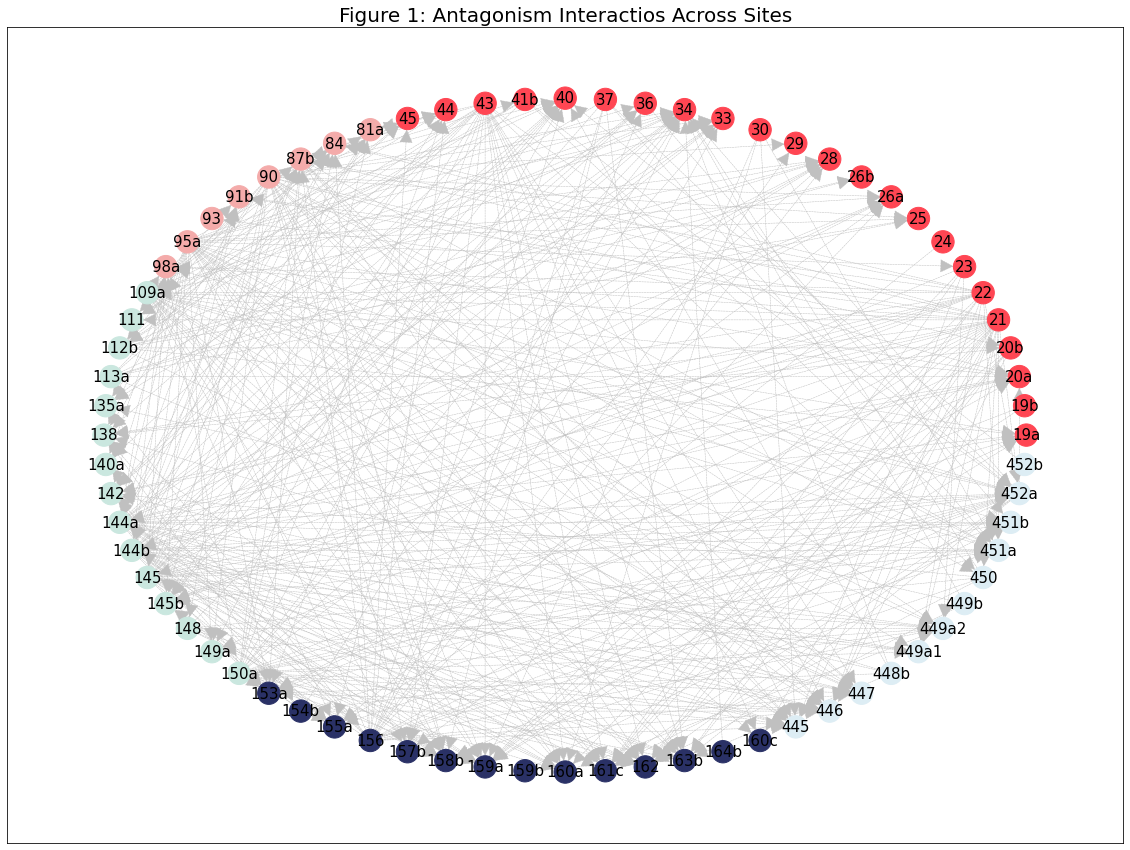

In [23]:
COLORSv = ["#FF4653", "#F4ABAA", "#CAE7DF", "#2A3166", "#DDEDF4"]   # Paleta del archivo
pltNetByGroups(NET, GROUPS1, COLORSv)

### Figura 1. Red de interaccciones de antagonismo entre cepas de diferentes sitios.

Cada nodo representa una cepa, cada etiqueta representa la identidad de la cepa.

Cada color representa el sitio de origen. Hay 5 sitios de origen.

Los triangulos grises representan la cabeza de la flecha de interacción. Si la flecha apunta a X, significa que X es sensible a la cepa de la cual sale la flecha.


Con esta representación podemos identificar algunos nodos relevantes por sitios.


GRUPOS: (FALTA LEYENDA)
- 1: Rojo
- 14b: Azul claro
- 5: Azul obscuro
- 4: Verde
- 3: Rosa

OBSERVACIONES:
- Todos los sitios tienen al menos una cepa que es muy antagonista y resistente a la vez. En la cima de la jerarquía. (Muchas lineas de salida sin triangulos en el nodo). La mayoría de estas cepas tienen interacciones de antagonismo contra todos los sitios restantes.

- Resalta el grupo 1 (Rojo), tiene el mayor número de cepas altamente antagonistas y resistentes a la vez. 43, 21, 22

- Resalta el grupo 4 (Verde), parece ser el que tiene más interacciones. Más estudios son necesarios, puede ser ilusión óptica.

- Resaltan cepas como la 24, 164b, 159b, .... Poco antagonizadas y poco sensibles, solo una interacción las mantiene sindo parte de la red.

- A pesar de que el grupo rojo es el más grande, parece tener menos interacciones.

- 159a y 160a parecen ser de las cepas más sensibles, ambas pertenecen al grupo 5 (Azul O). También el grupo 14b (Azul C) tiene cepas muy sensibles.


**Number of strains of each site of antagonist, sensitivity, ...**

In [24]:
def proportionsByGroups(DEGREESgroups):
    DEGREESgroups['TotalDegree'] = DEGREESgroups.loc[:,['OutDegree','InDegree']].sum(axis=1) # To obtain the degree

    GROUPS = set(DEGREESgroups["group"]) # To know the the classification
    
    # Inicialize Repositories
    OUTdegrees = dict.fromkeys(GROUPS, [])
    INdegrees = dict.fromkeys(GROUPS, [])
    TOTALdegrees = dict.fromkeys(GROUPS, [])
    
    # For each type of interactions: Antagonism, Sensitivity, Total
    for j, k in zip(["OutDegree", "InDegree", "TotalDegree"], [OUTdegrees, INdegrees, TOTALdegrees]):
        for i in GROUPS: # For each group the number of interactions of each type is calculeted
            NUM = sum(DEGREESgroups[DEGREESgroups.group == i][j])
            k[i] = NUM
    
    return(OUTdegrees, INdegrees, TOTALdegrees)
    

In [25]:
OUTd, INd, TOTALd = proportionsByGroups(DEGREES)

**Plot Pie chart of the proportion of strains that are atagonist, sensitive, part of any interaction**

Recquires three parameters (A dictionary {GROUP: AMOUNT OF STRAINS}): Antagonism; Sensitivity; Total degree

Recquires three optional parameters: SAVE(Do you wanna make a file with the figure?); TITLEsave(The name of the file);
TITLE


In [26]:
def pltProportionsBySite(OUTdegrees, INdegrees, TOTALdegrees, COLORS, SAVE = "T", TITLEsave = 'ProportionBySites.png', TITLE='Figure 2: Strains Proportion by Site'):
    fig, axs = plt.subplots(1, 3, figsize=(15,15))

    axs[0].pie(OUTdegrees.values(), colors = COLORS, labels = OUTdegrees.keys())
    axs[0].set_title("a) Proportion of antagonism across sites")
    axs[1].pie(INdegrees.values(), colors = COLORS, labels = INdegrees.keys())
    axs[1].set_title("b) Proportion of sensitivity across sites")
    axs[2].pie(TOTALdegrees.values(), colors = COLORS, labels = TOTALdegrees.keys())
    axs[2].set_title("c) Proportion of interactions across sites")
    fig.suptitle(TITLE, y = 0.67, fontsize=20)
    handles, labels = axs[2].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', title = "Group")
    if SAVE == "T":
        plt.savefig("../RESULTS/FIGURES/"+TITLEsave)
    plt.show()

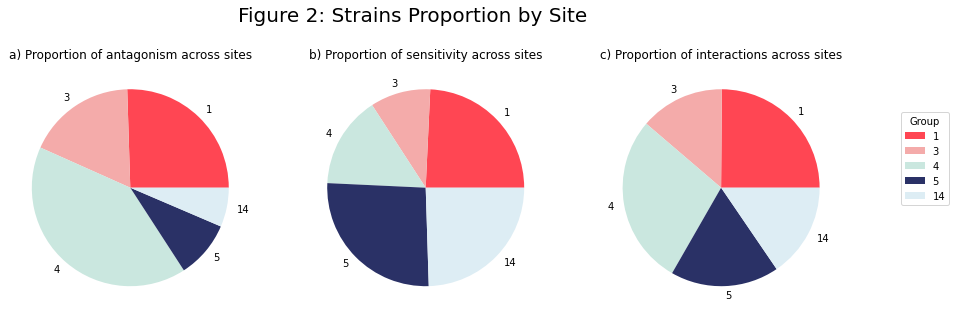

In [19]:
pltProportionsBySite(OUTd, INd, TOTALd)

### Figura 2: Proporción de cepas por grupo.

El grupo 1 (Rojo) es el más constante y equilibrado. Tiene la misma proporción de cepas sensibles y antagonistas.

Como había sugerido la red:

- El grupo 4 (Verde) y 3 (Rosa) tienen más antagonistas que sensibles.

- El grupo 4 (Azul O) y 14 (Azul C) tienen más sensibles que antagonistas.

El grupo 4 es el más sensible, mientras que el 1, 5 son los más antagonistas.

El grupo 4 es el que aporta más interacciones a la red.


### The fractions of classifications

In [27]:
def pltProportionsByClass(DEGREES, COLORS, SAVE = "T", TITLEsave = 'ProportionBySites.png', TITLE = 'Figure 3: Proportion of strains by Class'):
    A_NA = np.unique(np.array(DEGREES["ClassANA"]), return_counts=True)
    S_R = np.unique(np.array(DEGREES["ClassSR"]), return_counts=True)

    fig, axs = plt.subplots(1, 2, figsize=(15,15))
    axs[0].pie(A_NA[1], labels = [A_NA[0][0] + str(A_NA[1][0]), A_NA[0][1] + str(A_NA[1][1])], colors = COLORS)
    axs[0].set_title("a) Fraction of Antagonist VS Non antagonist strains", fontsize = 18)
    axs[1].pie(S_R[1], labels = [S_R[0][0] + str(S_R[1][0]), S_R[0][1] + str(S_R[1][1])], colors = COLORS)
    axs[1].set_title("b) Fraction of Resistant VS Sensitive strains", fontsize = 18)
    fig.suptitle(TITLE, y = 0.75, fontsize=20)
    if SAVE=="T":
        plt.savefig("../RESULTS/FIGURES/"+TITLEsave)
    plt.show()

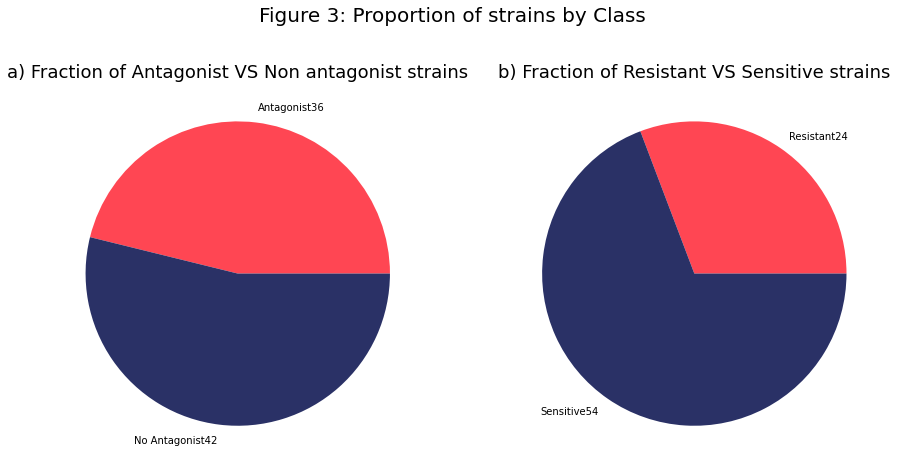

In [28]:
COLORS2 = ["#FF4653", "#2A3166"]
pltProportionsByClass(DEGREES, COLORS2)

### Figura 3: a) Comparación de la proporción de cepas antagonistas y no antagonistas. b) Comparación de la proporción de cepas sensibles contra resistentes.

A pesar de que la minoría es antagonista, la mayoría de las cepas son sensibles. Hay cerca de 20 cepas más que son sensibles de las que son antagonistas.

Fig. a) Hay más equilibrio entre la fracción de cepas antagonistas y la fracción de cepas no antagonistas. Por lo tanto, parece más común desarrollar métodos de ataque que métodos de defenza para sobrevivir.

### The degree Distribution

**¿How many interactions of any tipe has the network?**

In [29]:
def pltDistributionTotal(NET, COLOR, SAVE = "T", TITLE="Figure 4: Inteactions distribution", TITLEsave='DistributionInteractions.png'):
    DEGREEStotal = dict(nx.degree(NET)).values()
    plt.figure(figsize=(10,5))
    plt.hist(DEGREEStotal, len(DEGREEStotal), color = COLOR)
    plt.grid()
    plt.title(TITLE, fontsize = 20)
    plt.xlabel('Number of interactions per strain')
    plt.ylabel('Number of species with that number of interactions')
    if SAVE == "T":
        plt.savefig("../RESULTS/FIGURES/"+TITLEsave)
    plt.show()
    

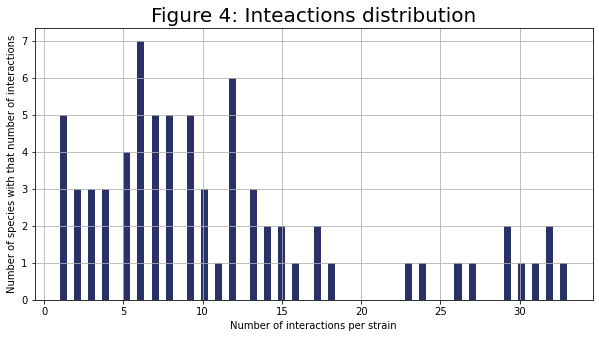

In [30]:
COLOR1 = "#2A3166"
pltDistributionTotal(NET, COLOR1)

### Figura 4: Distribución de grado de antagonismo.

Es más común tener pocas interacciones que tener muchas, por lo que la mayoría de las cepas son activas en la dinámica de antagonismo en la comunidad. Hay pocas cepas siendo más activas en la dinámica.

Hay pocas cepas con muchas interacciones.


In [32]:
def pltDistributionAntagonism(DEGREES, COLOR, SAVE = "T", TITLE="Figure 5: Antagonism of the strains", TITLEsave="DistributionInteractions.png"):
    plt.figure(figsize=(10,5))
    plt.hist(DEGREES["OutDegree"], len(DEGREES["OutDegree"]), color = COLOR)
    plt.grid()
    plt.title(TITLE, fontsize = 20)
    plt.xlabel('Number of antagonized strains (Outdegree)')
    plt.ylabel('Number of species')
    
    if SAVE == "T":
        plt.savefig("../RESULTS/FIGURES/"+TITLEsave)
    
    plt.show()
    
    
    

**¿How much antagonism is in the network? OutDegree**

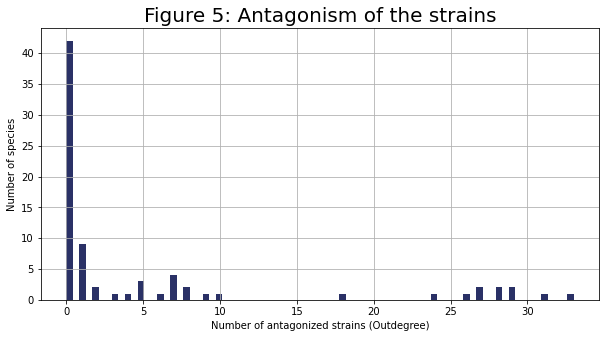

In [25]:
pltDistributionAntagonism(DEGREES, COLOR1)

### Figura 5: Distribución de antagonismo.

Hay pocas cepas que tienen un grado de antagonismo moderado. Parecen dividirse en dos grupos: Poco antagonistas o altamente antagonistas. Cepas antagonistas a una sola cepa son las más comunes, por lo que es más común la especificidad. 

Comparando con Fig. 4 y más adelante con Fig. 6, las cepas únicas con muchas interacciones encontradas en Fig. 4 deben ser completamente antagonistas ya que solo hay una y en esta figura encontramos cepas únicas antagonistas a muchas cepas (degree grande), por lo tanto, estas cepas son más generalistas. 

Puesto de otra manera, ya que hay cepas con out degree = [26-33], y solo había máximo dos cepas con degree = [26-33]; estas cepas con alto out degree tienen in degree = 0. Estas cepas están en la cima de la jerarquía y resalta que son muy antagonistas.

*Que haya muchas cepas antagonistas a una sola cepa puede sugerir que la dinámica de la comunidad tiene feedbacks largos.

**¿How much sensitivity is in the network? InDegree**

In [33]:
def pltDistributionSensitivity(DEGREES, COLOR, SAVE = "T", TITLE="Figure 6: Sensitivity of the strains", TITLEsave='DistributionSensitivity.png'):
    plt.figure(figsize=(10,5))
    plt.hist(DEGREES["InDegree"], len(DEGREES["InDegree"]), color = "#2A3166")
    plt.grid()
    plt.title(TITLE, fontsize = 20)
    plt.xlabel('Number of strains to wich there is sensitivity (Indegree)')
    plt.ylabel('Number of species')
    if SAVE == "T":
        plt.savefig("../RESULTS/DATA/"+TITLEsave)
    plt.show()

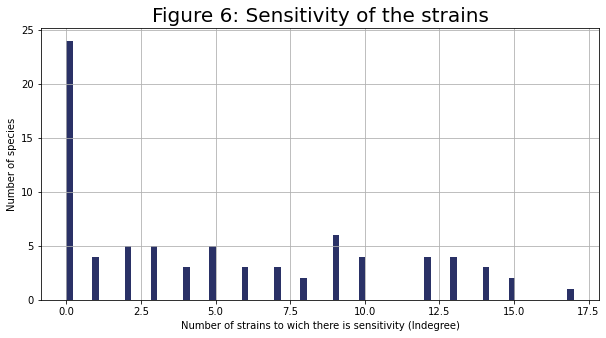

In [27]:
pltDistributionSensitivity(DEGREES, COLOR1)

### Figura 6: Distribución de sensibilidad

Hay más diversidad de número de interacciones de entrada.

Resalta nuevamente la ausencia de grados de entrada = [26-30]. La sensibilidad es baja, por lo que las cepas no están ante una presión tan grande, la presión selectiva que imponen las cepas antagonistas se distribuye mejor.

### Distribución de Clustering

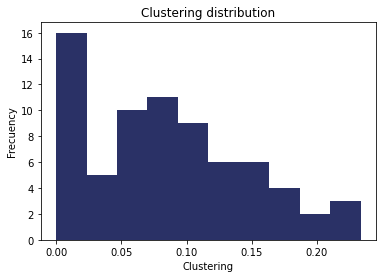

In [22]:
CLUSTER = nx.clustering(NET).values()
plt.hist(CLUSTER, color = "#2A3166")
plt.title("Clustering distribution")
plt.xlabel("Clustering")
plt.ylabel("Frecuency")
plt.show()

### IDK: To visualize the proportion of antagonism vs sensitivity

**For each strain, the degree of antagonism and sensitivity is plotted**


In [22]:
def pltIndexComparisions(DEGREES, COLORS, SAVE = "T", TITLEsave = 'AntagonismResistanceComparision1.png', TITLE = 'Figure 7: Comaprison of the index of antagonism and to index of sensitivity'):
    LABELS = list(DEGREES.index)
    LOC = np.arange(len(LABELS))
    X = list(DEGREES["OutDegree"])
    Y = list(DEGREES["InDegree"])


    plt.figure(figsize=(20,10))
    ax = plt.subplot(111)
    ax.bar(LOC, X, width=0.2, color= COLORS[0], align='center')
    ax.bar(LOC + 0.2, Y, width=0.2, color= COLORS[1], align='center')

    ax.set_ylabel('Amount of species', fontsize = 20)
    ax.set_xlabel('Speacies', fontsize = 20)
    ax.set_title(TITLE, fontsize = 20)
    ax.set_xticks(LOC)
    plt.xticks(rotation = 90)
    ax.set_xticklabels(LABELS, fontsize = 15)
    plt.legend(["Antagonism", "Sensitivity"], fontsize=20)
    if SAVE == "T":
        plt.savefig("../RESULTS/FIGURES/"+TITLEsave)
    plt.show()

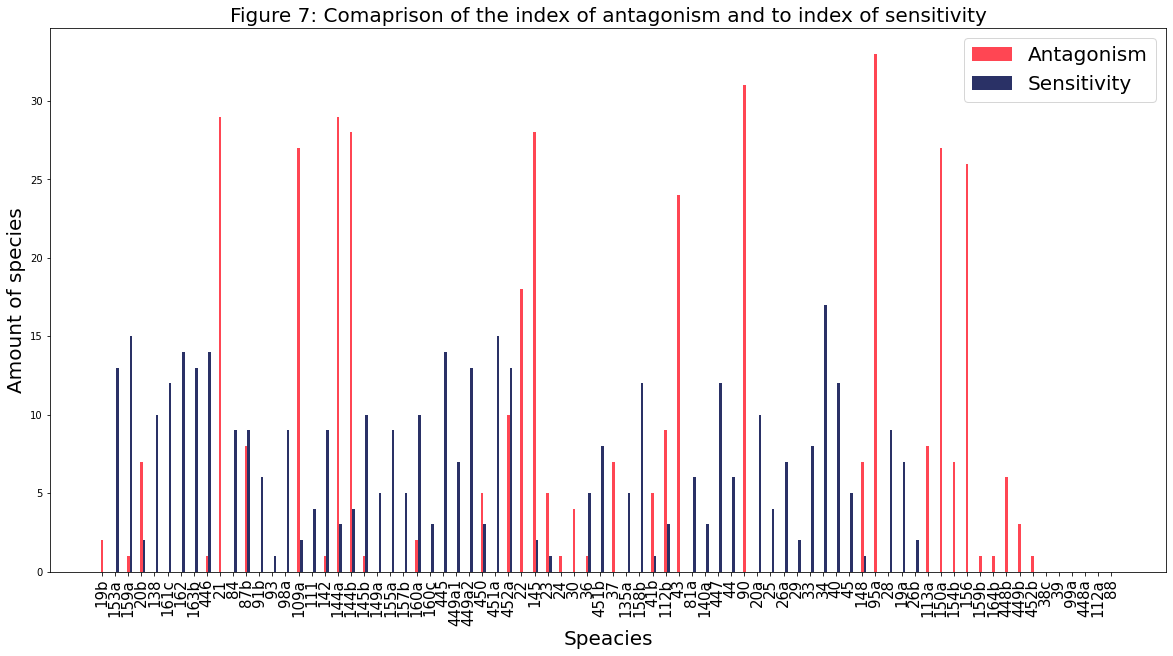

In [30]:
pltIndexComparisions(DEGREES, COLORS2)

### Figura 7: Comparación del indice de sensibilidadResistencia VS indice de AntagonismoNoantagonismo

Nuevamente, como lo expuesto en Fig. 4, resalta la división de cepas antagonistas en dos grupos, muy antagonistas o poco antagonistas.

**Parece ser que si la cepa es altamente sensible, es poco antagonista.**

**La mayoría de las cepas altamente antagonistas son poco sensibles, la mayoría de estas cepas son resistentes.**

**Por consiguiente, la mayoría de las cepas son sensibles o resistentes. Las cepas que son sensibles y resistentes a la vez tienen tienen bajos índices de antagonismo o sensibilidad; además, la diferencia entre estos dos índices suele ser alta.**

Resaltan cepas como la 87b o 425a, donde a pesar de haber un indice de antagonismo moderado, el indice de sensibilidad es mayor. Son excepciones a lo mencionado en el punto anterior.

Resaltan algunas cepas como 159b, 164b, 425b, 24 que parecen estar más aisladas de la dinámica de antagonismo (Solo tienen una interacción); pueden ser posibles targets para removerlas de la red. La cepa 93 es la única cepa poco sensible que tiene grado = 1, hay más cepas antagonistas con esta característica. 

Que haya muchas lineas rosas elevadas, en comparación con líneas azules nos indica que las cepas antagonistas distribuyen su antagonismo entre muchas cepas sensibles.



In [42]:
def pltIndexComparisions2(DEGREES, COLORS, SAVE = "T", TITLEsave = 'AntagonismResistanceComparision2.png', TITLE = 'Figure 7*: Comaprison of the index of antagonism and to index of sensitivity'):
    DEGREES = DEGREES.sort_values('InDegree', ascending=False)
    plt.figure(figsize=(20,10))
    DEGREES
    plt.plot(DEGREES["OutDegree"], color = COLORS[0], drawstyle="steps", lw =3)
    plt.plot(DEGREES["InDegree"], color = COLORS[1], drawstyle="steps", lw=5)
    plt.grid()
    plt.ylabel('Amount of species', fontsize = 20)
    plt.xlabel('Speacies', fontsize = 20)
    plt.title(TITLE, fontsize = 20)
    plt.xticks(rotation = 90)
    plt.legend(["Antagonism", "Sensitivity"])
    if SAVE == "T":
        plt.savefig("../RESULTS/FIGURES/"+TITLEsave)
    plt.show()

In [44]:

DEGREES = DEGREES.sort_values('OutDegree', ascending=True)
DEGREES


,OutDegree,InDegree,group,ClassANA,ClassSR,TotalDegree
111,0.0,4.0,4,No Antagonist,Sensitive,4.0
25,0.0,4.0,1,No Antagonist,Sensitive,4.0
157b,0.0,5.0,5,No Antagonist,Sensitive,5.0
135a,0.0,5.0,4,No Antagonist,Sensitive,5.0
149a,0.0,5.0,4,No Antagonist,Sensitive,5.0
...,...,...,...,...,...,...
145,28.0,2.0,4,Antagonist,Sensitive,30.0
21,29.0,0.0,1,Antagonist,Resistant,29.0
144a,29.0,3.0,4,Antagonist,Sensitive,32.0
90,31.0,0.0,3,Antagonist,Resistant,31.0


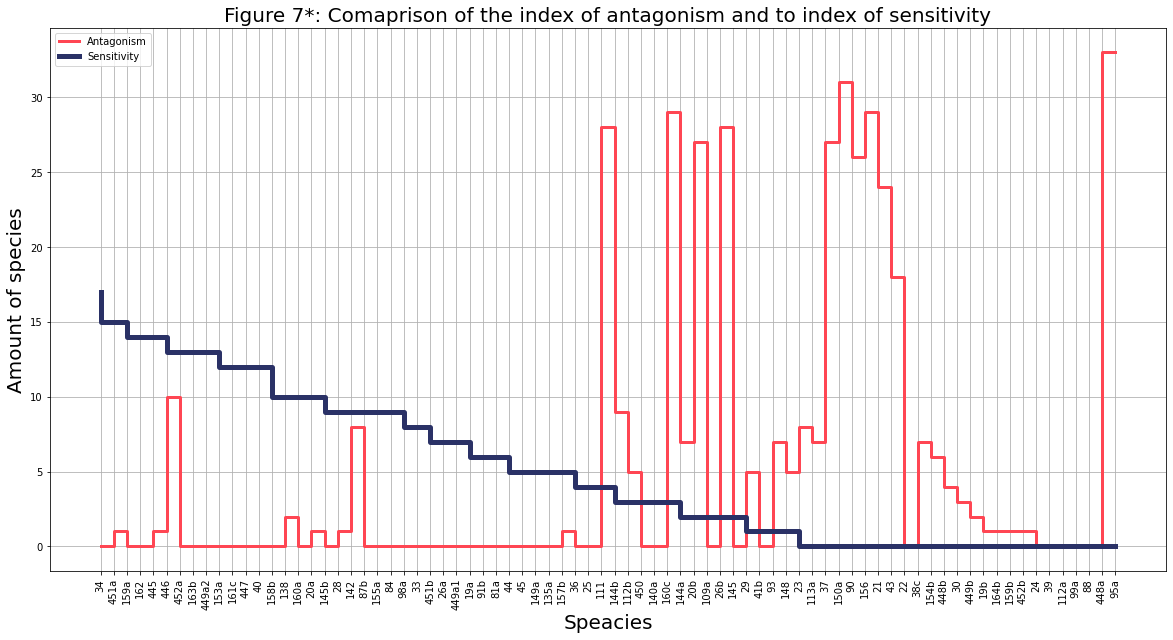

In [45]:
pltIndexComparisions2(DEGREES, COLORS2)

### Figura 6*: Otra representación de Fig. 7
The same of the las figure, but with another representation

### ALL PLOTS

In [33]:
def pltsAll(DEGREES, NET, GROUPS, COLORSd, SAVE = "T"):
    COLOR1 = COLORSd["COLOR1"]
    COLORS2 = COLORSd["COLORS2"]
    COLORS = COLORSd["COLORS"]
    pltNetByGroups(NET, GROUPS1, COLORS)
    OUTd, INd, TOTALd = proportionsByGroups(DEGREES)
    pltProportionsBySite(OUTd, INd, TOTALd, COLORS, SAVE)
    pltProportionsByClass(DEGREES, COLORS2, SAVE)
    pltUpsetByClass(DEGREES)
    pltDistributionTotal(NET, COLOR1, SAVE)
    pltDistributionAntagonism(DEGREES, COLOR1, SAVE)
    pltDistributionSensitivity(DEGREES, COLOR1, SAVE)
    pltIndexComparisions(DEGREES, COLORS2, SAVE)
    pltIndexComparisions2(DEGREES, COLORS2, SAVE)

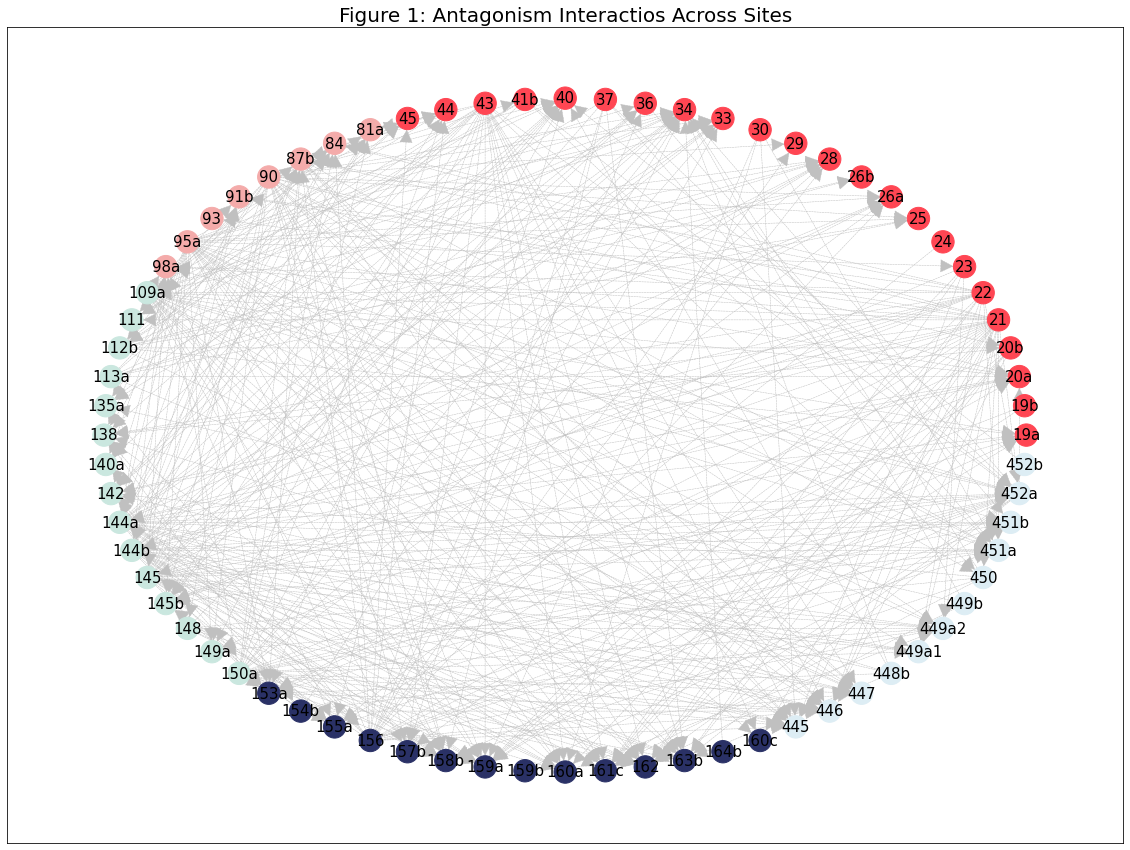

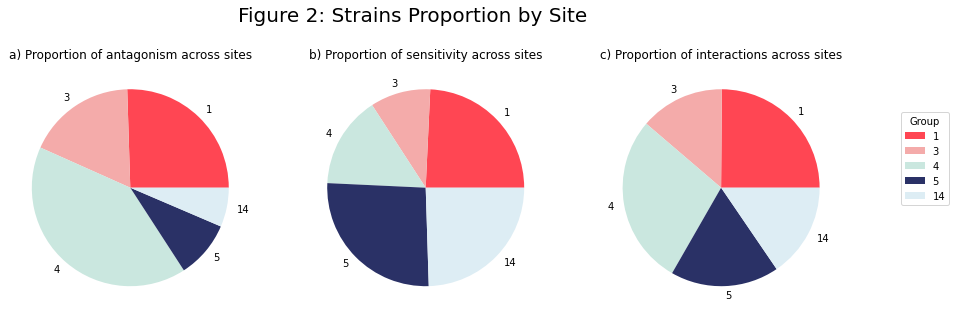

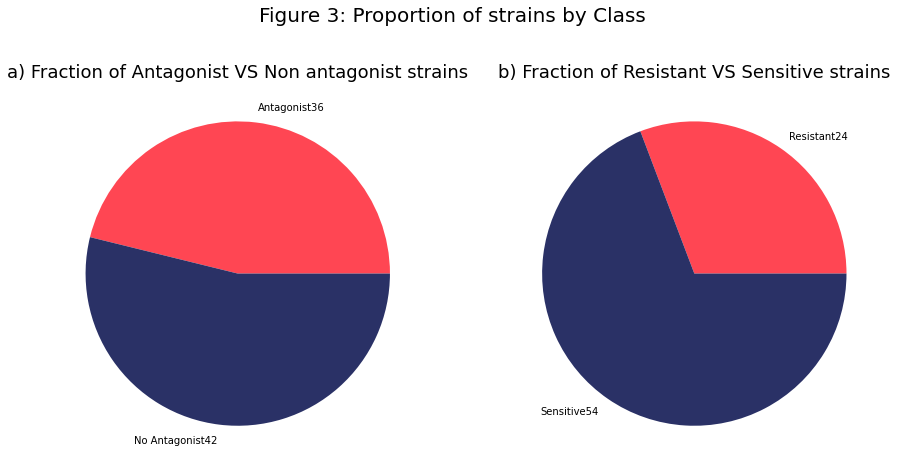

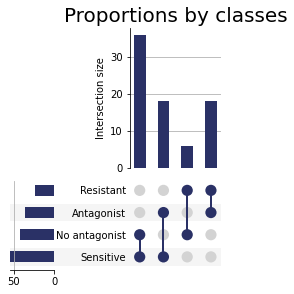

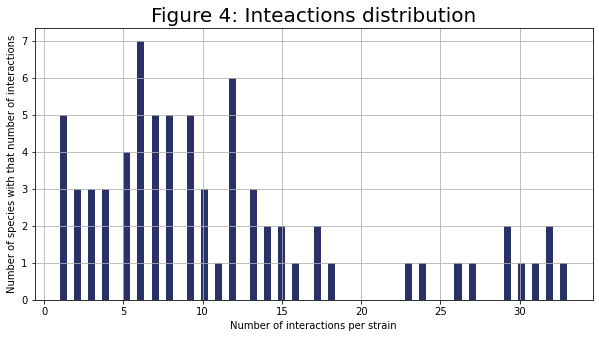

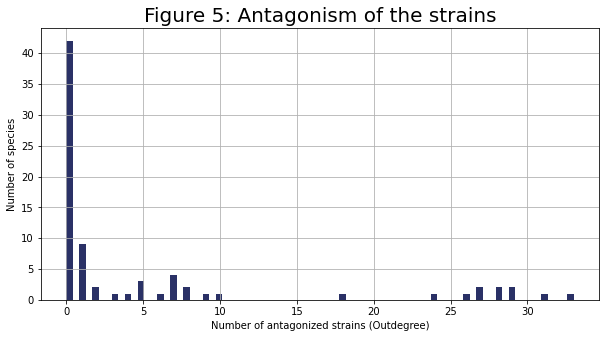

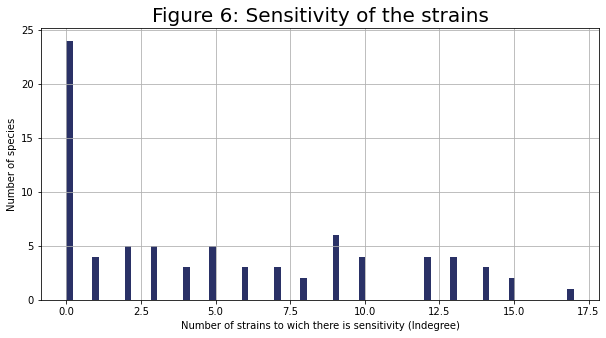

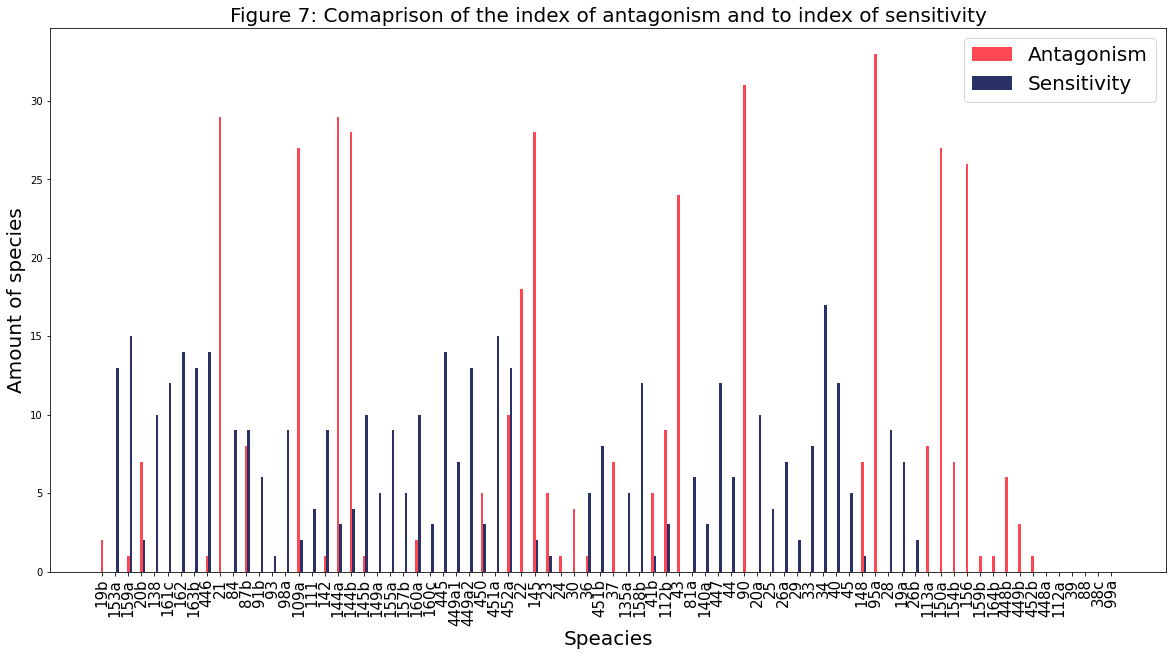

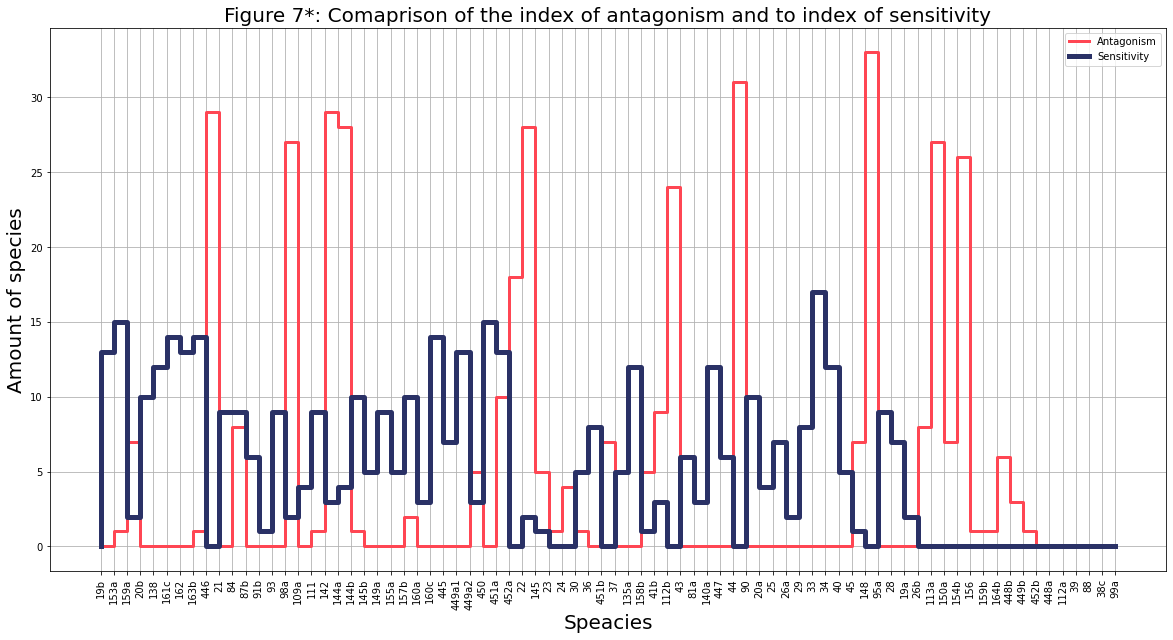

In [34]:
COLORSdic = {"COLORS":['#FF4653', '#F4ABAA', '#CAE7DF', '#2A3166', '#DDEDF4'], 
             "COLORS2":["#FF4653", "#2A3166"], 
             "COLOR1": ["#2A3166"],
            }
pltsAll(DEGREES, NET, GROUPS1, COLORSdic)

## DATA ANALYSIS

In [27]:
def top10(DEGREES):
    DEGREES.sort_values(by=['OutDegree'], inplace=True, ascending=False)
    HEADout = DEGREES.head(10)
    print("Top 10 more Antagonist strains\n", HEADout)

    DEGREES.sort_values(by=['InDegree'], inplace=True, ascending=False)
    HEADin = DEGREES.head(10)
    print("Top 10 more Sensitive strains\n", HEADin)
    
    return(HEADout, HEADin)

In [28]:
OUT10, IN10 = top10(DEGREES)

Top 10 more Antagonist strains
       OutDegree  InDegree  group    ClassANA    ClassSR  TotalDegree
95a        33.0       0.0      3  Antagonist  Resistant         33.0
90         31.0       0.0      3  Antagonist  Resistant         31.0
144a       29.0       3.0      4  Antagonist  Sensitive         32.0
21         29.0       0.0      1  Antagonist  Resistant         29.0
145        28.0       2.0      4  Antagonist  Sensitive         30.0
144b       28.0       4.0      4  Antagonist  Sensitive         32.0
109a       27.0       2.0      4  Antagonist  Sensitive         29.0
150a       27.0       0.0      4  Antagonist  Resistant         27.0
156        26.0       0.0      5  Antagonist  Resistant         26.0
43         24.0       0.0      1  Antagonist  Resistant         24.0
Top 10 more Sensitive strains
        OutDegree  InDegree  group       ClassANA    ClassSR  TotalDegree
34           0.0      17.0      1  No Antagonist  Sensitive         17.0
451a         0.0      15.0     1

In [29]:
def top10Sites(HEADout, HEADin, EDGE):
    print("Sites that antagonize the Top 10 more antagonist strains")
    for i in range(10):
        print("---------- ", HEADout.index[i], " ------------")
        print(set(EDGE[EDGE.OutputID == HEADout.index[i]]["OutSITE"]))

    print("Sites of sensitivity of Top 10 sensible strains")
    for i in range(10):
        print("---------- ", HEADin.index[i], " ------------")
        print(set(EDGE[EDGE.InputID == HEADin.index[i]]["InSITE"]))
    
    

In [30]:
top10Sites(OUT10, IN10, EDGE)

Sites that antagonize the Top 10 more antagonist strains
----------  95a  ------------
{1, 4, 5, 14}
----------  90  ------------
{1, 4, 5, 14}
----------  144a  ------------
{1, 3, 5, 14}
----------  21  ------------
{3, 4, 5, 14}
----------  145  ------------
{1, 3, 5, 14}
----------  144b  ------------
{1, 3, 5, 14}
----------  109a  ------------
{1, 3, 5, 14}
----------  150a  ------------
{1, 3, 5, 14}
----------  156  ------------
{1, 3, 4, 14}
----------  43  ------------
{3, 4, 5, 14}
Sites of sensitivity of Top 10 sensible strains
----------  34  ------------
{3, 4, 5, 14}
----------  451a  ------------
{1, 3, 4, 5}
----------  159a  ------------
{1, 3, 4}
----------  445  ------------
{1, 3, 4, 5}
----------  162  ------------
{1, 3, 4, 14}
----------  446  ------------
{1, 3, 4, 5}
----------  153a  ------------
{1, 3, 4, 14}
----------  449a2  ------------
{1, 3, 4, 5}
----------  163b  ------------
{1, 3, 4, 14}
----------  452a  ------------
{1, 3, 4, 5}


In [31]:
def top10HeadHierarchy(DEGREES):
    HEADhierarchy = DEGREES[(DEGREES.OutDegree > 0) & (DEGREES.InDegree == 0)].sort_values(by=["OutDegree"], ascending=False)
    HEADh10 = HEADhierarchy.head(10)
    print("Heads of the hierarchy\n", HEADh10)
    
    return(HEADh10)

In [32]:
HEADh = top10HeadHierarchy(DEGREES)

Heads of the hierarchy
       OutDegree  InDegree  group    ClassANA    ClassSR  TotalDegree
95a        33.0       0.0      3  Antagonist  Resistant         33.0
90         31.0       0.0      3  Antagonist  Resistant         31.0
21         29.0       0.0      1  Antagonist  Resistant         29.0
150a       27.0       0.0      4  Antagonist  Resistant         27.0
156        26.0       0.0      5  Antagonist  Resistant         26.0
43         24.0       0.0      1  Antagonist  Resistant         24.0
22         18.0       0.0      1  Antagonist  Resistant         18.0
113a        8.0       0.0      4  Antagonist  Resistant          8.0
37          7.0       0.0      1  Antagonist  Resistant          7.0
154b        7.0       0.0      5  Antagonist  Resistant          7.0


In [33]:
def top10BottomHierarchy(DEGREES):
    BOTTOMhierarchy = DEGREES[(DEGREES.OutDegree == 0) & (DEGREES.InDegree > 0)].sort_values(by=["InDegree"], ascending=False)
    BOTTOMh10 = BOTTOMhierarchy.head(10)
    print("Bottom of the hierarchy\n", BOTTOMh10)
    
    return(BOTTOMh10)

In [34]:
BOTTOMh = top10BottomHierarchy(DEGREES)

Bottom of the hierarchy
        OutDegree  InDegree  group       ClassANA    ClassSR  TotalDegree
34           0.0      17.0      1  No Antagonist  Sensitive         17.0
451a         0.0      15.0     14  No Antagonist  Sensitive         15.0
445          0.0      14.0     14  No Antagonist  Sensitive         14.0
162          0.0      14.0      5  No Antagonist  Sensitive         14.0
153a         0.0      13.0      5  No Antagonist  Sensitive         13.0
449a2        0.0      13.0     14  No Antagonist  Sensitive         13.0
163b         0.0      13.0      5  No Antagonist  Sensitive         13.0
161c         0.0      12.0      5  No Antagonist  Sensitive         12.0
40           0.0      12.0      1  No Antagonist  Sensitive         12.0
158b         0.0      12.0      5  No Antagonist  Sensitive         12.0


In [35]:
def objectivesAgressors(HEADout, HEADin, EDGE):
    OBJECTIVES = []
    for i in list(HEADout.index):
        APPEND = list(EDGE[EDGE.OutputID == i]["InputID"])
        OBJECTIVES = list(merge(OBJECTIVES, APPEND))
    OBJECTIVES = np.unique(np.array(OBJECTIVES), return_counts=True)
    OBJECTIVES = dict(zip(OBJECTIVES[0], OBJECTIVES[1]))
    
    AGRESSORS = []
    for i in list(HEADin.index):
        APPEND = list(EDGE[EDGE.InputID == i]["OutputID"])
        AGRESSORS = list(merge(AGRESSORS, APPEND))
        
    AGRESSORS = np.unique(np.array(AGRESSORS), return_counts=True)
    AGRESSORS = dict(zip(AGRESSORS[0], AGRESSORS[1]))
        
        
    print("Objectives of the top 10 more antagonists strains\n", OBJECTIVES)
    print("Agressors of the top 10 more sensitives strains\n", AGRESSORS)
    return(OBJECTIVES, AGRESSORS)

In [36]:
OBJECTIVES, AGRESSORS = objectivesAgressors(OUT10, IN10, EDGE)

Objectives of the top 10 more antagonists strains
 {'109a': 1, '111': 3, '112b': 2, '135a': 3, '138': 5, '140a': 3, '142': 4, '144a': 2, '144b': 3, '145': 1, '145b': 5, '148': 1, '149a': 4, '153a': 7, '155a': 7, '157b': 4, '158b': 7, '159a': 9, '160a': 9, '160c': 3, '161c': 7, '162': 9, '163b': 8, '19a': 5, '20a': 8, '20b': 1, '23': 1, '25': 2, '26a': 7, '28': 7, '29': 2, '33': 8, '34': 8, '36': 5, '40': 8, '41b': 1, '44': 5, '445': 10, '446': 10, '447': 9, '449a1': 6, '449a2': 9, '45': 3, '450': 3, '451a': 9, '451b': 6, '452a': 9, '81a': 6, '84': 6, '87b': 8, '91b': 5, '93': 1, '98a': 7}
Agressors of the top 10 more sensitives strains
 {'109a': 9, '112b': 1, '113a': 1, '144a': 10, '144b': 10, '145': 10, '148': 6, '150a': 10, '154b': 4, '156': 6, '160a': 1, '164b': 1, '19b': 2, '20b': 5, '21': 9, '22': 5, '23': 3, '30': 3, '37': 3, '41b': 2, '43': 7, '446': 1, '448b': 3, '449b': 2, '450': 1, '452a': 4, '87b': 5, '90': 7, '95a': 10}


## RANDOM: Control

In [83]:
def removeNodes(EDGElist, NODESlist):
    EDGE[EDGE['InputID'].isin(NODESrdm18) & EDGE['OutputID'].isin(NODESrdm18)]
    
    return(EDGElist)

In [84]:
NODES = list(NET.nodes())
NODESrdm18 = random.sample(NODES, len(NODES) - 19) 
NET2 = NET
NET2.remove_nodes_from(NODESrdm18)


Transforming matrix to edgelist....
Number of interactions in MATRIX:  11.0 	Number of interactions in edgelist:  11
Assigning Groups....
Removing intersites interactions....
Obtaining degrees....
Classifying...
DONE =D....


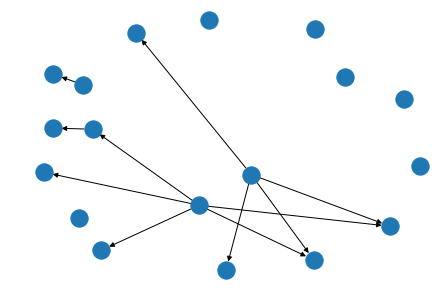

In [76]:
nx.draw(NET)
AD = nx.to_pandas_adjacency(NET)
A, B, C = processing(AD, GROUPS1)

In [103]:
A

,OutputID,InputID,Value,InSITE,OutSITE
0,450,149a,1.0,14,4
1,452a,162,1.0,14,5
2,113a,84,1.0,4,3
3,113a,25,1.0,4,1
4,113a,45,1.0,4,1
5,113a,26b,1.0,4,1
6,156,84,1.0,5,3
7,156,452a,1.0,5,14
8,156,36,1.0,5,1
9,156,135a,1.0,5,4


In [110]:
FALTAN = list(set(AD.index) - set(A.OutputID).union(set(A.InputID)))

In [111]:
#FALTAN = pd.DataFrame({"OutputID": FALTAN, "InputID": FALTAN, "Value": 1,})
SITE = []
for i in FALTAN:
    SITE.append(GROUPS1.loc[i].group)
    



In [112]:
FALTAN = pd.DataFrame({"OutputID": FALTAN, "InputID": FALTAN, "Value": 1, "InSITE": SITE, "OutSITE": SITE})
FALTAN

,OutputID,InputID,Value,InSITE,OutSITE
0,160c,160c,1,5,5
1,449a1,449a1,1,14,14
2,452b,452b,1,14,14
3,448b,448b,1,14,14
4,157b,157b,1,5,5
5,24,24,1,1,1


In [126]:
Q = A.append(FALTAN)

In [130]:
SET = C.loc(list(set(Q["OutputID"]).union(set(Q["InputID"]))))
C.loc[C.index.isin(SET)]

TypeError: unhashable type: 'list'

### SAVING RESULTS

In [ ]:
def saveResults(NAMES, DATA, DIR):
    for i,j in zip(NAMES, DATA):
        j.to_csv("DIR"+j, index=True, header=True)

In [ ]:
DEGREES.to_csv("../RESULTS/DATA/DegreesClass.csv", index=True, header=True)
EDGE.to_csv("../RESULTS/DATA/EdgeList.csv", index = False, header = True)